In [1]:
pip install numpy pandas matplotlib scikit-learn tensorflow yfinance


  Using cached scikit_learn-1.7.1-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached scipy-1.16.1-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     ---------------------------------------- 949.2/949.2 kB 14.5 MB/s  0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/11.0 MB ? eta -:-

  DEPRECATION: Building 'multitasking' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'multitasking'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [2]:
import yfinance as yf
import pandas as pd

# Download Tesla stock data
df = yf.download("TSLA", start="2020-01-01", end="2025-01-01")
print(df.head())

# Keep multiple features
data = df[["Open", "High", "Low", "Close", "Volume"]]


C:\Users\Dattaraj\AppData\Local\Temp\ipykernel_32440\1212715054.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("TSLA", start="2020-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           TSLA       TSLA       TSLA       TSLA       TSLA
Date                                                             
2020-01-02  28.684000  28.713333  28.114000  28.299999  142981500
2020-01-03  29.534000  30.266666  29.128000  29.366667  266677500
2020-01-06  30.102667  30.104000  29.333332  29.364668  151995000
2020-01-07  31.270666  31.441999  30.224001  30.760000  268231500
2020-01-08  32.809334  33.232666  31.215334  31.580000  467164500


In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

print("Scaled shape:", scaled_data.shape)


Scaled shape: (1258, 5)


In [4]:
def create_sequences(dataset, seq_length=60, target_col=3):  # target_col=3 -> "Close"
    X, y = [], []
    for i in range(len(dataset) - seq_length):
        X.append(dataset[i:i+seq_length])
        y.append(dataset[i+seq_length, target_col])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)
print("X shape:", X.shape, "y shape:", y.shape)


X shape: (1198, 60, 5) y shape: (1198,)


In [5]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(X_train.shape, X_test.shape)


(958, 60, 5) (240, 60, 5)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout

model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    GRU(100, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


e:\DL\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,101 (402.74 KB)

 Trainable params: 103,101 (402.74 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_data=(X_test, y_test), verbose=1)


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0248 - val_loss: 0.0040
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 12/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0

In [8]:
predictions = model.predict(X_test)

# Scale back to original Close price range
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[3], scaler.scale_[3]  # use Close column scaling
predictions_rescaled = predictions / close_scaler.scale_ + close_scaler.min_
y_test_rescaled = y_test / close_scaler.scale_ + close_scaler.min_


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


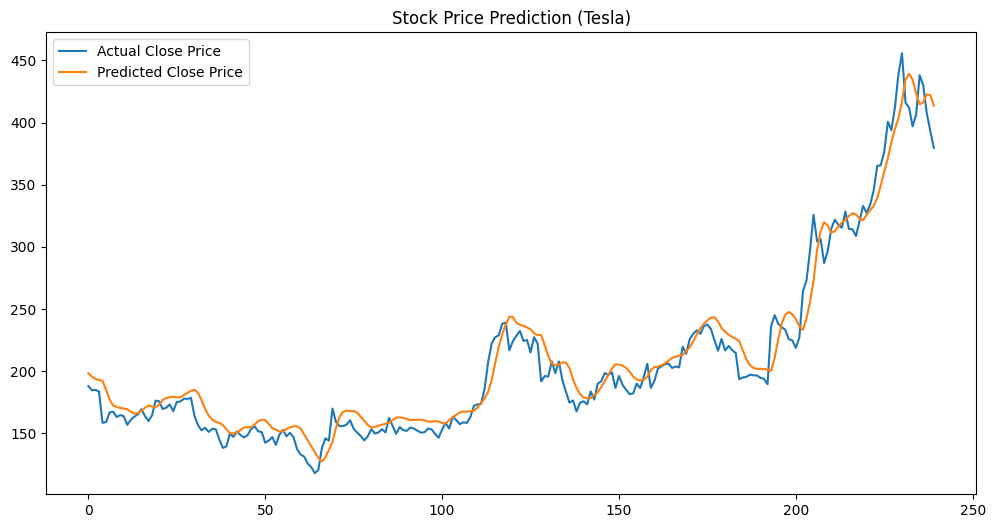

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled, label="Actual Close Price")
plt.plot(predictions_rescaled, label="Predicted Close Price")
plt.legend()
plt.title("Stock Price Prediction (Tesla)")
plt.show()
